## Example: $d=2$ Rayleigh-Benard convection in a semicircle

$$\Omega = \{(x, y)~:~0 < x^2 + y^2 < R_{\text{outer}}^2~,~y>0\}$$

$$\partial\Omega_{\text{arc}} = \{(x, y)~:~ x^2 + y^2 = R^2 \}$$

$$\partial\Omega_{\text{lower}} = \{(x, y)~:~ y=0 \}$$

$$c_0(r)=\mathcal{N}(r)~~,~~r=\sqrt{x^2 + y^2}$$

$$c\vert_{\partial\Omega_{\text{lower}}}=1$$

$$c\vert_{\partial\Omega_{\text{arc}}}=0$$

$$\textbf{e}_g=-\textbf{e}_y$$

$$
\begin{align*}
\phi &= 1 \\
\mathsf{D} &= \mathsf{I} \\ 
\mathsf{K} &= \mathsf{I}\\ 
\mu &= 1 \\
\rho(c) &= -c
\end{align*}
$$

In [1]:
import numpy as np
from lucifex.fdm import FiniteDifference, AB2, CN
from lucifex.mesh import circle_sector_mesh, mesh_boundary
from lucifex.solver import BoundaryConditions, OptionsPETSc
from lucifex.sim import integrate, configure_simulation
from lucifex.utils import CellType, SpatialPerturbation, triangulation
from lucifex.viz import plot_colormap, plot_mesh
from lucifex.io import write

from py.porous_convection import create_simulation


@configure_simulation(
    store_step=1,
    write_step=None,
)
def rayleigh_benard_semicircle(
    radius: float,
    Nradial: int = 100,
    cell: str = CellType.TRIANGLE,
    Ra: float = 5e2,
    c_eps: float = 1e-6,
    c_freq: int = 8,
    dt_max: float = 0.5,
    cfl_h: str | float = "hmin",
    cfl_courant: float = 0.75,
    D_adv: FiniteDifference | tuple[FiniteDifference, FiniteDifference] = (AB2, CN),
    D_diff: FiniteDifference = CN,
    psi_petsc: OptionsPETSc | None = None,
    c_petsc: OptionsPETSc | None = None,
    secondary: bool = False,
):
    r2 = lambda x: x[0]**2 + x[1]**2
    r = lambda x, sqrt=np.sqrt: sqrt(r2(x))
    dr = radius / Nradial
    Omega = circle_sector_mesh(dr, cell, 'semicircle')(radius, 180)
    dOmega = mesh_boundary(
        Omega, 
        {
            "lower": lambda x: x[1],
            "outer": lambda x: r2(x) - radius**2,
        },
    )
    c_bcs = BoundaryConditions(
        ("dirichlet", dOmega['lower'], 1.0),
        ("dirichlet", dOmega['outer'], 0.0),  
    )
    radial_noise = lambda x: c_eps * np.sin(c_freq * np.pi * (r(x, np.sqrt)) / radius)
    c_ics = SpatialPerturbation(
        0.0,
        radial_noise,
        Omega.geometry.x,
        c_eps,
        ) 
    density = lambda c: -c
    simulation = create_simulation(
        Omega=Omega, 
        dOmega=dOmega, 
        Ra=Ra, 
        c_ics=c_ics, 
        c_bcs=c_bcs, 
        density=density, 
        dt_max=dt_max, 
        cfl_h=cfl_h, 
        cfl_courant=cfl_courant,
        D_adv=D_adv, 
        D_diff=D_diff, 
        psi_petsc=psi_petsc, 
        c_petsc=c_petsc, 
        secondary=secondary,
    )
    return simulation

In [2]:
simulation = rayleigh_benard_semicircle(
    radius=1.0,
    Nradial=32,
    Ra=300.0, 
    c_eps=1e-3,  
    c_freq=8, 
    D_adv=AB2,
    D_diff=CN,
)

n_stop = 400
dt_init = 1e-6
n_init = 5
integrate(simulation, n_stop=n_stop, dt_init=dt_init, n_init=n_init)

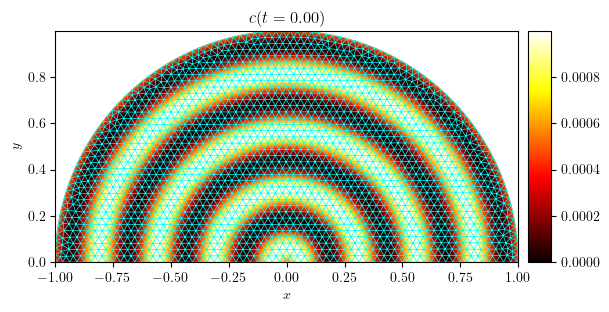

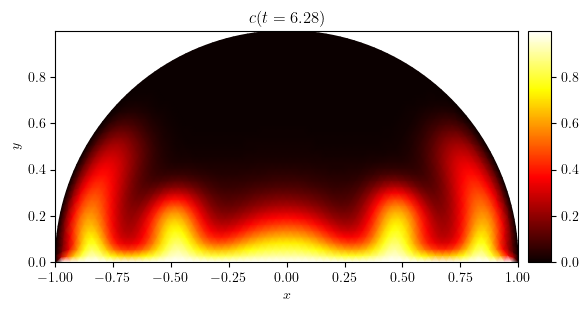

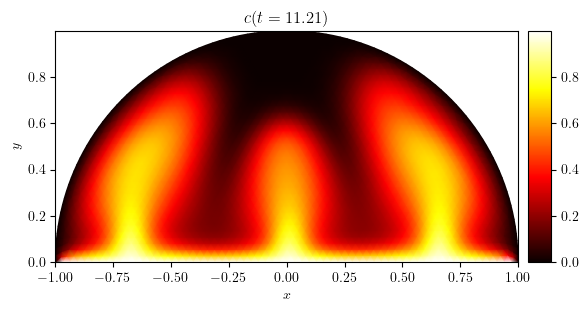

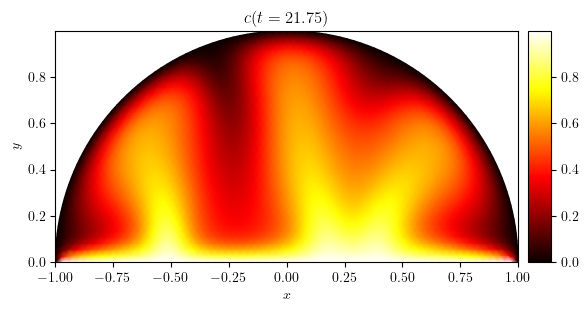

In [3]:
c = simulation['c']
mesh = c.mesh
mesh_tri = triangulation(c.function_space.mesh)
x, y = mesh_tri.x, mesh_tri.y

i_quart = int(0.25 * len(c.series))
i_mid = int(0.5 * len(c.series))
time_indices = (0, i_quart, i_mid,  -1)
for i in time_indices:
    c_tri = triangulation(c.series[i])
    fig, ax = plot_colormap(
        (mesh_tri, c_tri), 
        title=f'$c(t={c.time_series[i]:.2f})$',
        cartesian=False, 
    )
    if i == 0:
        plot_mesh(fig, ax, mesh, color='cyan', linewidth=0.5)
    write(fig, f'A14_rayleigh_benard_semicircle_t={c.time_series[i]:.2f}', './figures', close=False, pickle=False)